# Esimación de la perturbación determinística por tramos

Basado en el modelo de estados se evalúa las 2 variantes del algortimo
- utilizando la matriz de observabilidad para estimar el estado (memorizando las últimas n muestras de y)
- recursivo (utilizando solo el último valor de y) 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import control as ctrl
from scipy.signal import place_poles


Matriz de observabilidad Wo:
 [[1. 0.]
 [1. 1.]]
Ganancia del filtro para estimación del estado:
 [[0.993]
 [0.297]]
Autovalores del filtro: 
 [0.01 0.7 ]


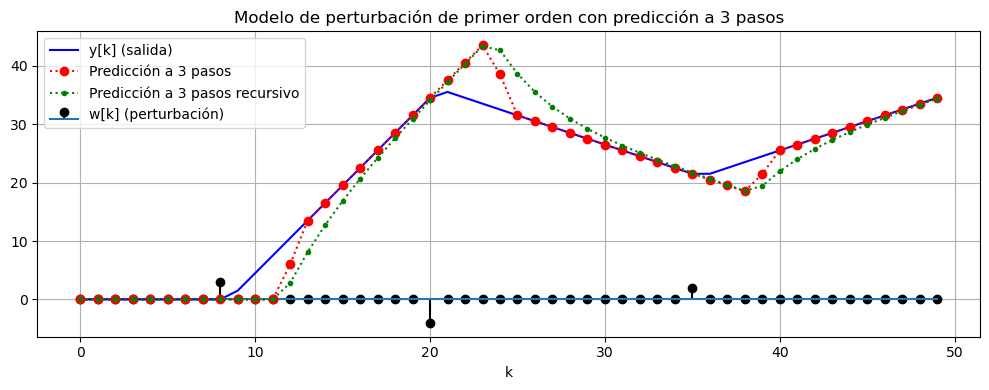

In [ ]:
# Matrices del modelo en espacio de estados
T = 1.0  
Phi = np.array([[1,T],[0,1]])
B = np.array([[T**2/2],[T]])
C = np.array([[1.0, 0]])
D = np.array([[0]])

# Doble integrador en espacio de estados discreto
G = ctrl.ss(Phi, B, C, D, 1)  # sample time = 1

# Simulación
N = 50
w = np.zeros(N)
w[8] = 3.0
w[20] = -4.0
w[35] = 2.0

# Simular la dinámica con control.forced_response
t = np.arange(N)
_, y, x = ctrl.forced_response(G, U=w, return_x=True)

# Predicción con matriz de observabilidad
n = G.nstates
m = 3  # pasos de predicción

# Matriz de observabilidad
Wo = np.vstack([C @ np.linalg.matrix_power(Phi, i) for i in range(n)])
print('Matriz de observabilidad Wo:\n',Wo)


# ------------------ Predicción
y_pred = np.zeros_like(y)
for k in range(n-1, N - m):
    Ypast = y[k-n+1:k+1]
    x_hat = np.linalg.inv(Wo) @ Ypast
    y_pred[k+m] = (C@(np.linalg.matrix_power(Phi, m + n - 1) @ x_hat))[0]

# ------------------ Predicción recursiva. 
# Mismo algoritmo pero implementado sobre la muestra anterior
y_pred_recursivo = np.zeros_like(y)
x_hat = np.zeros((n,N))

# Busco la ganancia del filtro K para que los autovalores de (I-KC)Phi den 0
# y así asegurar la convergencia del error en 1 sola muestra
# Con estos autovalores la matriz de transición para el error (I-KC)Phi es nilpotente, 
# esto significa que cualquier potencia mayor que 0 da la matriz nula
# Usamos Pole Placement pero observando que el K se calcula para Phi'(I-C'K') 
# por lo que se tiene que tomar el sistema transpuesto
polos_estimador = [0, 0.00000001]  # Polos deseados
#polos_estimador = [0.7, 0.01]  # Polos mostrando un estimador "lento"
Kt = place_poles(Phi.transpose(), (C@Phi).transpose(), polos_estimador)
K = Kt.gain_matrix.T  # Transponer para obtener K

print("Ganancia del filtro para estimación del estado:\n",K)  
# Verifico que los autovalores den cerca de lo deseado
eigvals,_ = np.linalg.eig((np.eye(n)- K @ C) @ Phi)
print("Autovalores del filtro: \n",eigvals)

for k in range(n-1, N - m):
    x_hat[:,k] = Phi @ x_hat[:,k-1] + K @ (y[k] - C @ Phi @ x_hat[:,k-1])     
    y_pred_recursivo[k+m] = (C@(np.linalg.matrix_power(Phi, m) @ x_hat[:,k]))[0]

# Graficar
plt.figure(figsize=(10, 4))
plt.stem(t, w, 'k', basefmt='', label='w[k] (perturbación)')
plt.plot(t, y, 'b-', label='y[k] (salida)')
plt.plot(t, y_pred, 'r:o', label='Predicción a 3 pasos')
plt.plot(t, y_pred_recursivo, 'g:.', label='Predicción a 3 pasos recursivo')
plt.legend()
plt.grid(True)
plt.title('Modelo de perturbación de primer orden con predicción a 3 pasos')
plt.xlabel('k')
plt.tight_layout()
plt.show()



## Desarrollo teórico del predictor basado en la matriz de observabilidad

La matriz de observabilidad se construye para un sistema discreto de la siguiente manera,

$$
W_o = \begin{bmatrix} C \\ C\Phi \\ \vdots \\ C\Phi^{n-1} \end{bmatrix}
$$

Para el sistema con entradas nulas resulta
$$
\begin{bmatrix} y_k \\ y_{k+1} \\ \vdots \\ y_{k+n-1} \end{bmatrix} = \begin{bmatrix} Cx_k \\ C\Phi x_k \\ \vdots \\ C\Phi^{n-1}x_k \end{bmatrix} = W_o x_k
$$

Desplanzado en $n-1$ muestras se puede escribir la expresión anterior como,
$$
\begin{bmatrix} y_{k-n+1} \\ y_{k-n} \\ \vdots \\ y_{k} \end{bmatrix} =  W_o x_{k-n+1}
$$

Si el sistema es observable entonces $W_o$ tiene inversa, y podemos usarla para estimar el estado en $k-n+1$ dadas las $n$ mediciones de las salidas entre el instante $k-n+1$ y $k$

$$
x_{k-n+1} = W_o^{-1}\begin{bmatrix} y_{k-n+1} \\ y_{k-n} \\ \vdots \\ y_{k} \end{bmatrix} 
$$

En este punto el problema es que estoy parado en k, y con la información de las salidas hasta este momento puedo estimar un estado n muestras hacia el pasado. Así como está no me sirve para predecir porque necesito dar un resultado $m$ pasos hacia el futuro. Para esto usamos nuevamente el modelo,

$$
\hat{x}_{k+m|k} = \Phi^{m+n-1} x_{k-n+1} \\
\hat{x}_{k+m|k} = \Phi^{m+n-1} W_o^{-1}\begin{bmatrix} y_{k-n+1} & y_{k-n} & ...  & y_{k} \end{bmatrix}^t
$$

## Desarrollo teórico del filtro recursivo y cálculo de ganancia

A partir de la ecuación recursiva hacemos aparecer la dinámica del error de estimación
$$
\hat{x}_k = \Phi \hat{x}_{k-1} + K [y_k - C\Phi \hat{x}_{k-1} ]  \\
x_k - \hat{x}_k = \Phi x_{k-1} - \Phi \hat{x}_{k-1} - K [y_k - C\Phi \hat{x}_{k-1} ] \\
e_k  = \Phi e_{k-1}  - K [y_k - C\Phi \hat{x}_{k-1} ]
$$

Expresemos el corchete en función del error
$$
e_k  = \Phi e_{k-1}  - K [C\Phi x_k - C\Phi \hat{x}_{k-1} ]\\
e_k  = \Phi e_{k-1}  - KC\Phi [ x_k -  \hat{x}_{k-1} ]\\
e_k  = \Phi e_{k-1}  - KC\Phi e_{k-1}\\
e_k  = (I - KC)\Phi e_{k-1}
$$

Entonces la dinámica del error de estimación está dada por la matriz de transición $(I - KC)\Phi$
Si buscamos que esta matriz sea nilpotente, es decir que toda potencia mayor a 0 se anula, entonces garantizamos que el error no se propaga a más de una muestra asegurando que el predictor es "perfecto".

Esto se consigue pidiendo que los autovalores sean 0 (o muy cercanos a 0).
Para conseguir esta meta de diseño utilizamos Pole Placement, observando que el algortimo está pensado para resolver una ecuación de lazo cerrado para $A-KB$. Para llevar la forma de nuestra ecuación a lo que necesita la función primero transponemos y luego hacemos:

$$
A-B K_p = ((I-KC)\Phi)^t\\
 =\Phi^t(I-KC)^t\\
 =\Phi^t(I-C^tK^t)\\
 =(\Phi^t-\Phi^tC^tK^t)\\
 =(\Phi^t-(C\Phi)^tK^t)\\
$$

Entonces obtenemos K transponiendo el resultado de hacer Pole Placement de un sistema dado por $A=\Phi^t$ con matriz de entrada $B=(C\Phi)^t$

